# Train datasets contain all users at 0 deg, Test datasets contain only 30, 45 and 60 deg. 
* Compare the effect of aspect angle on classification.


### Summary
*   Dataset 7 used 
*   3 second window
*   All movements
*   Cnn 64_128 model

## Train or Load Toggle
This variable sets whether to load results or train the model.
* If set to True then the model will be trained, history saved, new graphs generated and saved and new analysis produced.
* If set to False then a pre-trained version of the model will be loaded along with a history object.

In [0]:
TRAIN_MODEL = False

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [3]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\baseline_model':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"    
    
DATA_PATH = BASE_PATH + 'data/processed/3/dataset_7/'
MODEL_PATH = BASE_PATH + 'models/baseline_model/train_all_0_test_30_45_60/'
RESULTS_PATH = BASE_PATH + 'results/baseline_model/train_all_0_test_30_45_60/'
REPORT_PATH = BASE_PATH + 'reports/baseline_model/train_all_0_test_30_45_60/'
    
from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
batch_size = 100
nb_epoch = 20

# input image dimensions
img_rows, img_cols = 75, 75

In [0]:
datasets = {
    "train_data": DATA_PATH + "train_data.pkl",
    "train_labels": DATA_PATH + "train_labels.pkl",
    "test_data_30": DATA_PATH + "test_data_30.pkl",
    "test_labels_30": DATA_PATH + "test_labels_30.pkl",
    "test_data_45": DATA_PATH + "test_data_45.pkl",
    "test_labels_45": DATA_PATH + "test_labels_45.pkl",
    "test_data_60": DATA_PATH + "test_data_60.pkl",
    "test_labels_60": DATA_PATH + "test_labels_60.pkl"
}
loaded_data = load_data.load_data_specific_files(datasets)
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(loaded_data["train_labels"], nb_classes)
Y_test = np_utils.to_categorical(loaded_data["test_labels_60"], nb_classes)
X_train = loaded_data["train_data"].astype('float32')
X_test = loaded_data["test_data_60"].astype('float32')
X_train /= 255
X_test /= 255 

In [0]:
results = {'30':{}, '45':{}, '60':{}}
for key, value in results.items():
    value["acc"] = None
    value["loss"] = None
    value["classification_report"] = None
    value["confusion_matrix"] = None

## Training and Evaluating Models

In [0]:
if TRAIN_MODEL:
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
    # train the model using SGD + momentum.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_data=(X_test, Y_test),
        shuffle=True, 
        verbose=1)
    model.save(MODEL_PATH + "model.h5")
    with open(RESULTS_PATH + "history.pkl", "wb") as file:
        pickle.dump(history.history, file)
    
else:
    model = load_model(MODEL_PATH + "model.h5")
    with open(RESULTS_PATH + "history.pkl", "rb") as file:
        history = pickle.load(file)

In [10]:
for angle, value in results.items(): 
    X_test = loaded_data["test_data_" + angle]
    y_test = loaded_data["test_labels_" +angle]
    y_test = np.reshape(y_test, (len(y_test), 1))
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)
    value["loss"] = evaluation[0]
    value["accuracy"] = evaluation[1]

    y_pred = model.predict_classes(X_test)
    value["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,target_names=target_names)
    value["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

 300/9104 [..............................] - ETA: 5s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


9104/9104 [==============================] - 6s 608us/step


## Analysis and Saving of Results

In [0]:
save_graph = True
save_report = True

### Plot and Save graph

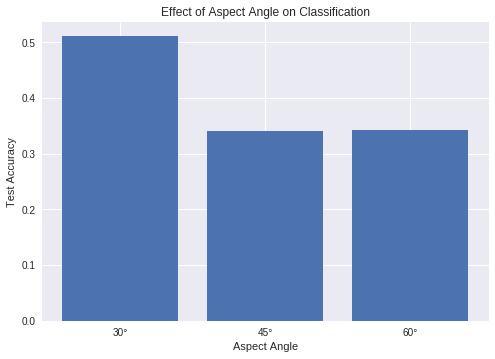

In [18]:
visualize.plot_evaluation_bar(
    results,
    ['30°', '45°', '60°'],
    "Effect of Aspect Angle on Classification",
    'Aspect Angle',
    'Test Accuracy',
    save=save_graph,
    path=REPORT_PATH + "aspect_angle_comparison.svg")

### Confusion Matricies

#### 30 Degrees Aspect Angle

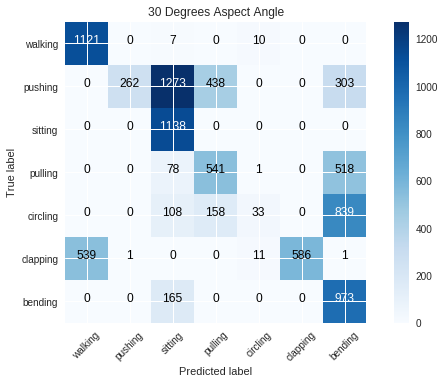

In [19]:
plot_confusion_matrix.plot_confusion_matrix(
    results["30"]['confusion_matrix'],
    target_names,
    title="30 Degrees Aspect Angle",
    save=save_graph,
    path=REPORT_PATH + "confusion_matrix_30.svg")

#### 45 Degrees Aspect Angle

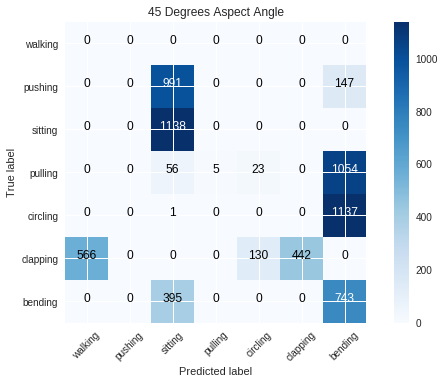

In [20]:
plot_confusion_matrix.plot_confusion_matrix(
    results["45"]['confusion_matrix'],
    target_names,
    title="45 Degrees Aspect Angle",
    save=save_graph,
    path=REPORT_PATH + "confusion_matrix_45.svg")

#### 60 Degrees Aspect Angle

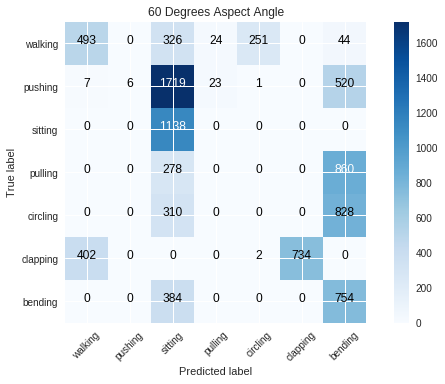

In [21]:
plot_confusion_matrix.plot_confusion_matrix(
    results["60"]['confusion_matrix'],
    target_names,
    title="60 Degrees Aspect Angle",
    save=save_graph,
    path=REPORT_PATH + "confusion_matrix_60.svg")

### Save Classification Report and Confusion Matricies

In [22]:
if save_report:
    with open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') as file:

        for folder_name, value in results.items():    
            file.write("--------------------------------------------------\n") 
            file.write("Test set name: " + folder_name + "\n") 
            print("Test set name:", folder_name, "degrees")
            file.write("Accuracy: " + str(np.round(value["accuracy"], 2)) + "\n")
            file.write("Loss: " + str(np.round(value["loss"], 2)) + "\n")
            file.write("Classification Report:\n") 
            file.write(value['classification_report'])
            print(value['classification_report'], "\n\n\n")
            file.write("Confusion Matrix:\n") 
            file.write(np.array2string(value['confusion_matrix']) + "\n")



Test set name: 30 degrees
             precision    recall  f1-score   support

    walking       0.68      0.99      0.80      1138
    pushing       1.00      0.12      0.21      2276
    sitting       0.41      1.00      0.58      1138
    pulling       0.48      0.48      0.48      1138
   circling       0.60      0.03      0.06      1138
   clapping       1.00      0.51      0.68      1138
    bending       0.37      0.86      0.52      1138

avg / total       0.69      0.51      0.44      9104
 



Test set name: 45 degrees
             precision    recall  f1-score   support

    walking       0.00      0.00      0.00         0
    pushing       0.00      0.00      0.00      1138
    sitting       0.44      1.00      0.61      1138
    pulling       1.00      0.00      0.01      1138
   circling       0.00      0.00      0.00      1138
   clapping       1.00      0.39      0.56      1138
    bending       0.24      0.65      0.35      1138

avg / total       0.45      0.34      